In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from sklearn.preprocessing import LabelEncoder
import time
%matplotlib inline

import tensorflow_datasets as tfds
import tensorflow_probability as tfp

from PIL import Image
from tqdm import tqdm
from tqdm.notebook import tqdm

import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

import torch
import torch.nn as nn
import torch.optim as optim
import torchbnn as bnn

gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

/Users/caoyuxin/opt/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is available


In [3]:
## Load the dateset
TRAIN_DIR = './FER2013/train/'
TEST_DIR = './FER2013/test/'

In [7]:
# Initialize image data generator with rescaling
train_data_gen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.3,
)

validation_data_gen = ImageDataGenerator(rescale=1./255)

# Preprocess all train images
train_generator = train_data_gen.flow_from_directory(
        TRAIN_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

# Preprocess all validation images
validation_generator = validation_data_gen.flow_from_directory(
        TEST_DIR,
        target_size=(48, 48),
        batch_size=64,
        color_mode="grayscale",
        class_mode='categorical',
        shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [5]:
train_X = np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
train_Y = np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
val_X = np.concatenate([validation_generator.next()[0] for i in range(validation_generator.__len__())])
val_Y = np.concatenate([validation_generator.next()[1] for i in range(validation_generator.__len__())])

## Architecture 1

### DCNN

In [4]:
# create model structure
emotion_model = Sequential([
    #C1 + P1
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #C2 + P2
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    Conv2D(32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C3 + P3
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    #Dropout(0.2),
    
    #FC1
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    #FC2
    Dense(128, activation='relu'),   
    Dropout(0.2),
    
    #FC3
    Dense(7, activation='softmax')
])

emotion_model.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

emotion_model.summary()

# Train the neural network/model
emotion_model_info = emotion_model.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

2022-12-07 03:18:18.404220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-12-07 03:18:18.404876: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        9248      
                                                                 
 dropout (Dropout)           (None, 44, 44, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 32)        9248      
                          

2022-12-07 03:18:19.107721: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-12-07 03:18:19.639647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


447/448 [============================>.] - ETA: 0s - loss: 1.8273 - accuracy: 0.2494

2022-12-07 03:18:36.654878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 19s 33ms/step - loss: 1.8273 - accuracy: 0.2492 - val_loss: 1.7976 - val_accuracy: 0.2567
Epoch 2/60
448/448 [==============================] - 14s 30ms/step - loss: 1.7849 - accuracy: 0.2554 - val_loss: 1.7665 - val_accuracy: 0.2603
Epoch 3/60
448/448 [==============================] - 14s 30ms/step - loss: 1.7413 - accuracy: 0.2866 - val_loss: 1.6663 - val_accuracy: 0.3396
Epoch 4/60
448/448 [==============================] - 13s 30ms/step - loss: 1.6596 - accuracy: 0.3430 - val_loss: 1.5992 - val_accuracy: 0.3790
Epoch 5/60
448/448 [==============================] - 13s 30ms/step - loss: 1.6245 - accuracy: 0.3643 - val_loss: 1.5574 - val_accuracy: 0.4114
Epoch 6/60
448/448 [==============================] - 13s 30ms/step - loss: 1.5904 - accuracy: 0.3794 - val_loss: 1.5223 - val_accuracy: 0.4223
Epoch 7/60
448/448 [==============================] - 13s 30ms/step - loss: 1.5598 - accuracy: 0.3942 - val_loss: 1.5008 - val_accuracy: 0.4354
Epo

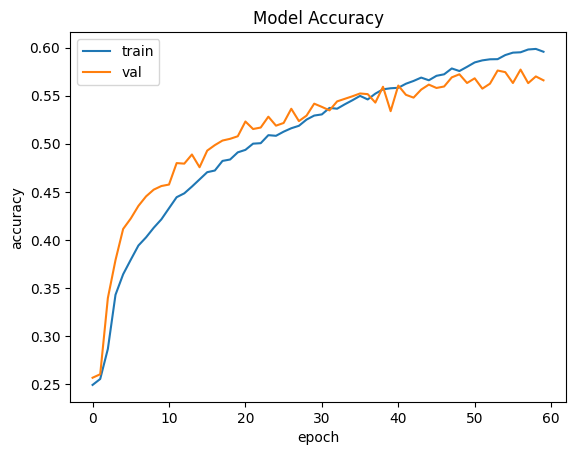

In [5]:
# plot accuracy
plt.plot(emotion_model_info.history['accuracy'])
plt.plot(emotion_model_info.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

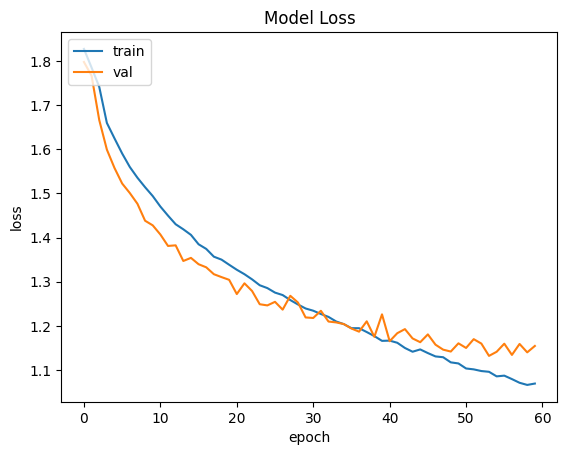

In [6]:
# plot loss
plt.plot(emotion_model_info.history['loss'])
plt.plot(emotion_model_info.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### DCNN: Architecture 2

In [13]:
# create model structure
dcnn_model2 = Sequential([
    #C1 + P1
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same", input_shape=(48, 48, 1)),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    #C2 + P2
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C3 + P3
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #C4 + P4
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    Conv2D(64, kernel_size=(3, 3), activation='relu', padding="same"),
    MaxPooling2D(pool_size=(2, 2)),
    
    #FC1
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    
    #FC2
    Dense(128, activation='relu'),   
    Dropout(0.2),
    
    #FC3
    Dense(7, activation='softmax')
])

dcnn_model2.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.0001,epsilon=1e-06),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

dcnn_model2.summary()

# Train the neural network/model
dcnn_model2_info = dcnn_model2.fit(
        train_generator,
        steps_per_epoch=28709 // 64,
        epochs=60,
        validation_data=validation_generator,
        validation_steps=7178 // 64)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_46 (Conv2D)          (None, 48, 48, 32)        320       
                                                                 
 conv2d_47 (Conv2D)          (None, 48, 48, 32)        9248      
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 24, 24, 32)        9248      
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 32)        9248      
                                                      

2022-12-07 12:08:45.526160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - ETA: 0s - loss: 1.8308 - accuracy: 0.2426

2022-12-07 12:09:00.414738: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


448/448 [==============================] - 17s 35ms/step - loss: 1.8308 - accuracy: 0.2426 - val_loss: 1.8176 - val_accuracy: 0.2473
Epoch 2/60
448/448 [==============================] - 15s 33ms/step - loss: 1.8035 - accuracy: 0.2540 - val_loss: 1.7615 - val_accuracy: 0.2972
Epoch 3/60
448/448 [==============================] - 15s 34ms/step - loss: 1.7328 - accuracy: 0.3017 - val_loss: 1.6399 - val_accuracy: 0.3636
Epoch 4/60
448/448 [==============================] - 15s 34ms/step - loss: 1.6595 - accuracy: 0.3440 - val_loss: 1.5912 - val_accuracy: 0.3768
Epoch 5/60
448/448 [==============================] - 15s 33ms/step - loss: 1.6072 - accuracy: 0.3680 - val_loss: 1.5068 - val_accuracy: 0.4202
Epoch 6/60
448/448 [==============================] - 15s 33ms/step - loss: 1.5642 - accuracy: 0.3911 - val_loss: 1.4815 - val_accuracy: 0.4378
Epoch 7/60
448/448 [==============================] - 14s 32ms/step - loss: 1.5251 - accuracy: 0.4104 - val_loss: 1.4445 - val_accuracy: 0.4471
Epo

448/448 [==============================] - 15s 32ms/step - loss: 0.9480 - accuracy: 0.6430 - val_loss: 1.0751 - val_accuracy: 0.6066
Epoch 58/60
448/448 [==============================] - 15s 32ms/step - loss: 0.9415 - accuracy: 0.6459 - val_loss: 1.0874 - val_accuracy: 0.5992
Epoch 59/60
448/448 [==============================] - 14s 32ms/step - loss: 0.9366 - accuracy: 0.6472 - val_loss: 1.0808 - val_accuracy: 0.6030
Epoch 60/60
448/448 [==============================] - 14s 32ms/step - loss: 0.9328 - accuracy: 0.6498 - val_loss: 1.0846 - val_accuracy: 0.6037


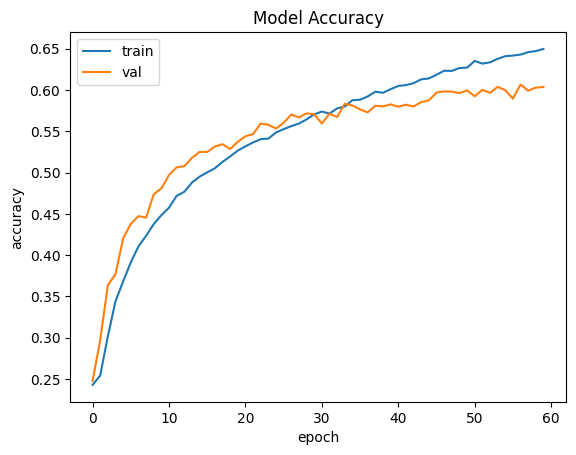

In [15]:
# plot accuracy
plt.plot(dcnn_model2_info.history['accuracy'])
plt.plot(dcnn_model2_info.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

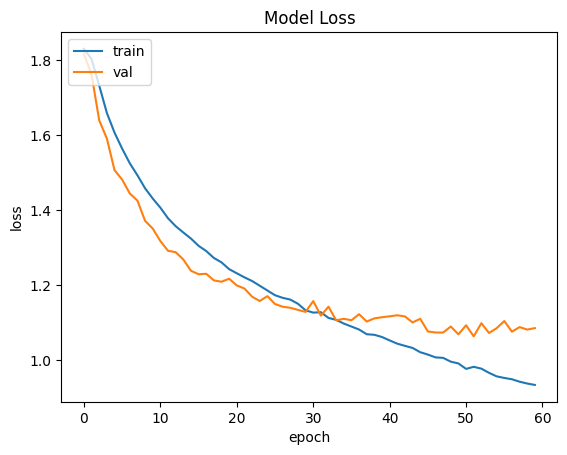

In [16]:
# plot loss
plt.plot(dcnn_model2_info.history['loss'])
plt.plot(dcnn_model2_info.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()